In [1]:
# Importing libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import os
import xml.etree.ElementTree as ET
from cmlbootstrap import CMLBootstrap 

In [2]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector
from pyspark.ml.classification import LinearSVC

In [3]:
# Setting STORAGE
# Set the setup variables needed by CMLBootstrap
HOST = os.getenv("CDSW_API_URL").split(":")[0] + "://" + os.getenv("CDSW_DOMAIN")
USERNAME = os.getenv("CDSW_PROJECT_URL").split("/")[6]  # args.username  # "vdibia"
API_KEY = os.getenv("CDSW_API_KEY")
PROJECT_NAME = os.getenv("CDSW_PROJECT")

# Instantiate API Wrapper
cml = CMLBootstrap(HOST, USERNAME, API_KEY, PROJECT_NAME)

try:
    storage = os.environ["STORAGE"]
except:
    if os.path.exists("/etc/hadoop/conf/hive-site.xml"):
        tree = ET.parse("/etc/hadoop/conf/hive-site.xml")
        root = tree.getroot()
        for prop in root.findall("property"):
            if prop.find("name").text == "hive.metastore.warehouse.dir":
                storage = (
                    prop.find("value").text.split("/")[0]
                    + "//"
                    + prop.find("value").text.split("/")[2]
                )
    else:
        storage = "/user/" + os.getenv("HADOOP_USER_NAME")
    storage_environment_params = {"STORAGE": storage}
    storage_environment = cml.create_environment_variable(storage_environment_params)
    os.environ["STORAGE"] = storage
    
print(os.environ["STORAGE"])

s3a://ps-uat2


In [4]:
# Creating Spark session
spark = SparkSession\
    .builder\
    .appName("Credit Scoring")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
    .config("spark.yarn.access.hadoopFileSystems",os.environ["STORAGE"])\
    .getOrCreate()

Setting spark.hadoop.yarn.resourcemanager.principal to svadivel


In [5]:
# Read source data
df = spark.read.option('inferschema','true').csv(
  os.environ["STORAGE"] + "/credit_demo_sv/LoanStats_2015_original.csv",
  header=True,
  sep=',',
  nullValue='NA'
)

In [6]:
#Count number of nulls for each column:
%time df_pd_null_pct = df.select([((F.count(F.when(F.isnan(c) | F.col(c).isNull(), c))/df.count())*100).alias(c) for c in df.columns])

CPU times: user 176 ms, sys: 42.7 ms, total: 219 ms
Wall time: 46 s


In [7]:
null_cols = df_pd_null_pct.toPandas().T[(df_pd_null_pct.toPandas().T > 1).any(axis=1)].index

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [8]:
# Dropping NULL columns
df_non_null = df.drop(*null_cols)

In [9]:
len(df.columns), len(df_non_null.columns)

(105, 68)

In [10]:
df_non_null.printSchema()

root
 |-- acc_now_delinq: integer (nullable = true)
 |-- acc_open_past_24mths: integer (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- annual_inc: double (nullable = true)
 |-- application_type: string (nullable = true)
 |-- avg_cur_bal: integer (nullable = true)
 |-- bc_open_to_buy: integer (nullable = true)
 |-- bc_util: double (nullable = true)
 |-- chargeoff_within_12_mths: integer (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- delinq_amnt: integer (nullable = true)
 |-- desc: string (nullable = true)
 |-- dti: double (nullable = true)
 |-- earliest_cr_line: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: integer (nullable = true)
 |-- grade: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- id: string (nullable = true)
 |-- initial_list_

In [11]:
cat_cols = [item[0] for item in df_non_null.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df_non_null.dtypes if item[1].startswith('in') or item[1].startswith('dou')]
num_features, cat_features = num_cols, cat_cols

In [12]:
print(cat_cols)

['addr_state', 'application_type', 'desc', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade', 'home_ownership', 'id', 'initial_list_status', 'int_rate', 'issue_d', 'loan_status', 'purpose', 'revol_util', 'sub_grade', 'term', 'title', 'verification_status', 'zip_code']


### Dropping null rows

In [13]:
df_non_null = df_non_null.dropna()

# Label Column

loan_status is the 'label' column

In [14]:
df_non_null.groupBy('loan_status').count().show()

+------------------+-----+
|       loan_status|count|
+------------------+-----+
|        Fully Paid|28765|
|           Default|    2|
|   In Grace Period|  631|
|       Charged Off|10679|
|Late (31-120 days)| 1196|
|           Current|36849|
| Late (16-30 days)|  236|
+------------------+-----+



`Create derived column 'is_default' from 'loan_status'`

In [15]:
df_labelled = df_non_null.withColumn("is_default", F.when((df_non_null["loan_status"] == "Charged Off")|(df_non_null["loan_status"] == "Default"), 1).otherwise(0))
df_labelled.groupBy('is_default').count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|         1|10681|
|         0|67677|
+----------+-----+



## String Column analysis

- earliest_cr_line seems like usable column along with sec_app_earliest_cr_line but sec_app_earliest_cr_line is null for majority of the rows. IGNORED.
- emp_length is categorical but requires to be translated to meaning feature. IGNORED.
- emp_title has too many distinct values (30984). IGNORED.
- id columns is empty for all rows. IGNORED
- issue_d does not contain a meaningful information. IGNORED.
- sub_grade is not used. grade is used instead. IGNORED.
- term does not offer value in prediction. IGNORED.
- verification_status may lead to bias. IGNORED.
- zip_code can lead to bias. IGNORED.

In [16]:
# Drop unwanted columns
drop_str_cols = ['addr_state', 'desc', 'earliest_cr_line', 'emp_length', 'emp_title', 'id', 'issue_d', 'loan_status', 'sub_grade', 'term', 'title', 'verification_status', 'zip_code']
select_str_cat_cols = ['application_type', 'grade', 'home_ownership', 'initial_list_status', 'purpose']

In [17]:
#Application Type is a categorical column
from pyspark.sql.functions import trim
df_labelled.select(trim('application_type')).filter(trim('application_type') != '').show(5)

df_labelled.select(trim('application_type')).distinct().show()

+----------------------+
|trim(application_type)|
+----------------------+
|            Individual|
|            Individual|
|            Individual|
|            Individual|
|            Individual|
+----------------------+
only showing top 5 rows



+----------------------+
|trim(application_type)|
+----------------------+
|             Joint App|
|            Individual|
+----------------------+



In [18]:
df_labelled.groupBy('emp_length').count().orderBy('emp_length').show()

+----------+-----+
|emp_length|count|
+----------+-----+
|    1 year| 5116|
| 10+ years|26374|
|   2 years| 6855|
|   3 years| 6227|
|   4 years| 4486|
|   5 years| 4710|
|   6 years| 3062|
|   7 years| 2869|
|   8 years| 3971|
|   9 years| 3015|
|  < 1 year| 6934|
|       n/a| 4739|
+----------+-----+



In [19]:
df_labelled.select('emp_title').distinct().count()

30714

In [20]:
df_labelled.groupBy('grade').count().show(20)

+-----+-----+
|grade|count|
+-----+-----+
|    F| 1492|
|    E| 5477|
|    B|23981|
|    D|10474|
|    C|22906|
|    A|13713|
|    G|  315|
+-----+-----+



In [21]:
ct = df_labelled.select('home_ownership').distinct().count()
print("Distinct values for home_ownership: ", ct)
df_labelled.groupBy('home_ownership').count().show()

Distinct values for home_ownership:  4


+--------------+-----+
|home_ownership|count|
+--------------+-----+
|           OWN| 8889|
|          RENT|30741|
|      MORTGAGE|38727|
|           ANY|    1|
+--------------+-----+



In [22]:
ct = df_labelled.select('initial_list_status').distinct().count()
print("Distinct values for initial_list_status: ", ct)
df_labelled.groupBy('initial_list_status').count().show()

Distinct values for initial_list_status:  2


+-------------------+-----+
|initial_list_status|count|
+-------------------+-----+
|                  f|16989|
|                  w|61369|
+-------------------+-----+



In [23]:
ct = df_labelled.select('int_rate').distinct().count()
print("Distinct values for int_rate: ", ct)
df_labelled.select('int_rate').show()

Distinct values for int_rate:  80
+--------+
|int_rate|
+--------+
|   9.80%|
|   5.32%|
|  18.49%|
|  15.77%|
|  19.89%|
|  10.78%|
|  16.59%|
|   7.49%|
|  13.99%|
|  10.78%|
|  12.88%|
|   6.49%|
|  17.27%|
|  13.99%|
|  11.99%|
|  17.27%|
|  12.88%|
|   6.49%|
|  17.27%|
|  14.85%|
+--------+
only showing top 20 rows



In [24]:
ct = df_labelled.select('issue_d').distinct().count()
print("Distinct values for issue_d: ", ct)
df_labelled.groupBy('issue_d').count().show()

Distinct values for issue_d:  3


+--------+-----+
| issue_d|count|
+--------+-----+
|Nov-2015|34419|
|Oct-2015|   52|
|Dec-2015|43887|
+--------+-----+



In [25]:
ct = df_labelled.select('purpose').distinct().count()
print("Distinct values for purpose: ", ct)
df_labelled.groupBy('purpose').count().show()

Distinct values for purpose:  12


+------------------+-----+
|           purpose|count|
+------------------+-----+
|             other| 4153|
|    small_business|  685|
|debt_consolidation|44497|
|       credit_card|19853|
|            moving|  446|
|          vacation|  404|
|  renewable_energy|   43|
|             house|  253|
|               car|  682|
|    major_purchase| 1591|
|           medical|  873|
|  home_improvement| 4878|
+------------------+-----+



In [26]:
ct = df_labelled.select('title').distinct().count()
print("Distinct values for title: ", ct)
#df_non_null.groupBy('title').count().show(20, truncate=False)
df_labelled.groupBy('title','is_default').count().orderBy('title','is_default').show(40, truncate=False)

Distinct values for title:  14


+-----------------------+----------+-----+
|title                  |is_default|count|
+-----------------------+----------+-----+
|                       |0         |117  |
|                       |1         |12   |
|Business               |0         |543  |
|Business               |1         |140  |
|Car financing          |0         |606  |
|Car financing          |1         |74   |
|Credit card refinancing|0         |17702|
|Credit card refinancing|1         |2115 |
|Debt consolidation     |0         |37878|
|Debt consolidation     |1         |6564 |
|Green loan             |0         |35   |
|Green loan             |1         |8    |
|Home buying            |0         |204  |
|Home buying            |1         |49   |
|Home improvement       |0         |4251 |
|Home improvement       |1         |608  |
|Major purchase         |0         |1367 |
|Major purchase         |1         |220  |
|Medical expenses       |0         |726  |
|Medical expenses       |1         |142  |
|Moving and

In [27]:
ct = df_labelled.select('verification_status').distinct().count()
print("Distinct values for verification_status: ", ct)
#df_non_null.groupBy('verification_status').count().show()
df_verification_status = df_labelled.groupBy('verification_status','is_default').count().orderBy('verification_status','is_default')

Distinct values for verification_status:  3


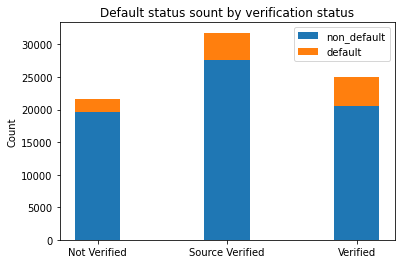

In [28]:
import matplotlib.pyplot as plt
labels = df_labelled.select('verification_status').distinct().orderBy('verification_status').toPandas()['verification_status']
non_default = df_labelled.groupBy('verification_status','is_default').count().orderBy('verification_status').filter('is_default == 0').toPandas()['count']
default = df_labelled.groupBy('verification_status','is_default').count().orderBy('verification_status').filter('is_default == 1').toPandas()['count']
width = 0.35

fig, ax = plt.subplots()

ax.bar(labels, non_default, width, label='non_default')
ax.bar(labels, default, width, bottom=non_default, label='default')

ax.set_ylabel('Count')
ax.set_title('Default status sount by verification status')
ax.legend()

plt.show()

In [29]:
df_labelled.groupBy('verification_status','is_default').count().orderBy('verification_status').filter('is_default == 1').toPandas()['count']

0    2009
1    4262
2    4410
Name: count, dtype: int64

# Feature Engineering

## Categorical String columns to vector

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

def vectorize_cat_cols(df, cat_str_cols):
    idx_cols = [column+"_index" for column in cat_str_cols]
    enc_cols = [idx_column+"_vec" for idx_column in idx_cols]
    indexers = StringIndexer(inputCols=cat_str_cols, outputCols=idx_cols)
    encoders = OneHotEncoder(inputCols=idx_cols, outputCols=enc_cols, dropLast=False)
    pipeline = Pipeline(stages=[indexers, encoders])
    df_r = pipeline.fit(df).transform(df)
    df_r = df_r.drop(*idx_cols)
    df_r.select(*cat_str_cols, *enc_cols).toPandas()
    return df_r
    

In [31]:
df_vec = vectorize_cat_cols(df_labelled, select_str_cat_cols)
#vectorize_cat_cols(df_labelled, select_str_cat_cols)

In [32]:
df_vec.toPandas()

,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,...,total_il_high_credit_limit,total_rev_hi_lim,verification_status,zip_code,is_default,application_type_index_vec,grade_index_vec,home_ownership_index_vec,initial_list_status_index_vec,purpose_index_vec
0,0,8,KS,65000.0,Individual,10086,41055,17.1,0,0,...,105910,73200,Not Verified,660xx,0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,1,VT,150000.0,Individual,61551,24661,44.0,0,0,...,51081,45500,Not Verified,054xx,0,"(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0,8,IN,75000.0,Individual,7176,23476,59.9,0,0,...,31758,83600,Verified,471xx,0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,7,OH,175000.0,Individual,51015,21569,50.3,0,0,...,146568,43400,Not Verified,430xx,0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,1,FL,44000.0,Individual,19041,0,102.4,0,0,...,127033,12600,Verified,322xx,0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78353,0,2,MO,38000.0,Individual,12173,1091,87.7,0,0,...,44639,13900,Source Verified,657xx,0,"(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(0.0, 1.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78354,0,1,IL,50000.0,Individual,2059,1955,49.9,0,0,...,33116,8200,Not Verified,629xx,0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78355,0,0,TX,50000.0,Individual,10298,60,99.8,0,0,...,16386,27200,Verified,750xx,1,"(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0, 0.0)","(0.0, 1.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78356,0,4,NJ,99000.0,Individual,36221,2405,81.6,0,0,...,48377,16700,Not Verified,070xx,0,"(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0)","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### int_rate column converted from str to float by removing %

In [33]:
df_vec = df_vec.withColumn("int_rate", F.expr("substring(int_rate, 1, length(int_rate)-1)").cast('double'))

In [34]:
df_vec = df_vec.withColumn("revol_util", F.expr("substring(revol_util, 1, length(revol_util)-1)").cast('double'))

## Removing unwanted string columns and loan_status column

In [35]:
drop_cols = drop_str_cols
drop_cols.append('loan_status')

In [36]:
df_vec = df_vec.drop(*drop_cols)
df_vec = df_vec.drop(*select_str_cat_cols)

In [37]:
#df_vec.toPandas()

## Handling numerical feature columns

In [38]:
#num_cols

In [39]:
# Standard Scaler
def make_pipeline_numeric(spark_df):
    stages= []

    scale_cols = spark_df.columns
    scale_cols.remove('is_default')

    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=scale_cols, outputCol="features")
    stages += [assembler]

    #Standard scaler
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=True)
    stages += [scaler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)

    return out_df

### Moving target column to the end

In [40]:
df_res = df_vec.select(*num_cols, 'is_default')

In [41]:
df_model = make_pipeline_numeric(df_res)

In [42]:
def extract(row):
    return tuple(row.scaledFeatures.toArray().tolist()) + (row.is_default, )

In [43]:
#cat_vec_cols = [cat_col+'_index_vec' for cat_col in select_str_cat_cols]
#df_scaled = df_model.rdd.map(extract).toDF(df_vec.columns)
df_reb = df_model.select('scaledFeatures', 'is_default')
df_reb_table = df_reb.rdd.map(extract).toDF([*num_cols, 'is_default'])
#df_reb_table.toPandas()

# Baseline Model

## Train Test Split

In [44]:
#df_base = df_reb_table.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'is_default'])
df_base = df_reb_table

In [45]:
train = df_base.sampleBy("is_default", fractions={0: 0.6, 1: 0.6}, seed=10)

In [46]:
test = df_base.subtract(train)

In [47]:
from pyspark.ml.classification import RandomForestClassifier

def make_pipeline(spark_df, label_col):        
     
    #for c in spark_df.columns:
    #    spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    #cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    cols = spark_df.columns
    
    #spark_df = spark_df.withColumn('acc_now_delinq',F.abs(spark_df['acc_now_delinq']))
    #spark_df = spark_df.withColumn('acc_open_past_24mths',F.abs(spark_df['acc_open_past_24mths']))
    #spark_df = spark_df.withColumn('annual_inc',F.abs(spark_df['annual_inc']))
    #spark_df = spark_df.withColumn('avg_cur_bal',F.abs(spark_df['avg_cur_bal']))
    #spark_df = spark_df.withColumn('funded_amnt',F.abs(spark_df['funded_amnt']))
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    stages += [assembler]    
    
    #Scaling features
    #scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    #stages += [scaler]
    
    
    #RF Classifier
    #rf = LinearSVC(featuresCol='features', labelCol='is_default')
    rf = RandomForestClassifier(labelCol=label_col, featuresCol='features', numTrees=10)
    stages += [rf]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [48]:
pipelineModel = make_pipeline(train, 'is_default')

In [49]:
df_model_pred = pipelineModel.transform(test)

In [50]:
#df_model_pred.show()

In [51]:
#output_data = df_model_pred.rdd.map(lambda x: (x["is_default"], x["prediction"]))

In [52]:
df_model_pred.orderBy('is_default','prediction').groupBy('is_default','prediction').count().show()

+----------+----------+-----+
|is_default|prediction|count|
+----------+----------+-----+
|         1|       0.0|  576|
|         0|       0.0|26973|
|         1|       1.0| 3770|
+----------+----------+-----+



# Baseline Model Evaluation

In [53]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [54]:
evaluator = BinaryClassificationEvaluator(labelCol="is_default", rawPredictionCol="prediction")

In [55]:
auroc = evaluator.evaluate(df_model_pred, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(df_model_pred, {evaluator.metricName: "areaUnderPR"})

print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.9337
Area under PR Curve: 0.9429


In [56]:
y_true = df_model_pred.select(['is_default']).collect()
y_pred = df_model_pred.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     26973
           1       0.60      0.52      0.56      4346

    accuracy                           0.89     31319
   macro avg       0.76      0.73      0.75     31319
weighted avg       0.88      0.89      0.88     31319



In [57]:
if auroc > 0.7:
    pipelineModel.write().overwrite().save(os.environ["STORAGE"]+"/svadivel/pipeline/baseline/")

# Stopping Spark

In [58]:
spark.stop()